<a href="https://colab.research.google.com/github/edcalderin/Competencia_Puntaje_Recencia/blob/master/Competencia_Puntaje_Recencia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predecir el Puntaje de Recencia en Papers de Investigación
*Notebook created by Erick Calderin*

**Web site:** https://www.datasource.ai/es/home/data-science-competitions-for-startups/predecir-el-puntaje-de-recencia-en-papers-de-investigacion

## Modules

In [1]:
# Utilities

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# For ML
from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.cluster import DBSCAN
import multiprocessing as mp

For NLP

In [18]:
# Install
!pip install -U spacy
!python -m spacy download en_core_web_sm
!python -m spacy download es_core_news_sm
!python -m spacy download pt_core_news_sm

     |████████████████████████████████| 6.4 MB 5.0 MB/s 
     |████████████████████████████████| 621 kB 45.4 MB/s 
     |████████████████████████████████| 10.1 MB 56.6 MB/s 
     |████████████████████████████████| 456 kB 40.6 MB/s 
     |████████████████████████████████| 42 kB 1.4 MB/s 
  Attempting uninstall: catalogue
    Found existing installation: catalogue 1.0.0
    Uninstalling catalogue-1.0.0:
      Successfully uninstalled catalogue-1.0.0
  Attempting uninstall: srsly
    Found existing installation: srsly 1.0.5
    Uninstalling srsly-1.0.5:
      Successfully uninstalled srsly-1.0.5
  Attempting uninstall: thinc
    Found existing installation: thinc 7.4.0
    Uninstalling thinc-7.4.0:
      Successfully uninstalled thinc-7.4.0
  Attempting uninstall: spacy
    Found existing installation: spacy 2.2.4
    Uninstalling spacy-2.2.4:
      Successfully uninstalled spacy-2.2.4


2021-08-10 05:05:02.708694: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
     |████████████████████████████████| 13.6 MB 70 kB/s 
  Attempting uninstall: en-core-web-sm
    Found existing installation: en-core-web-sm 2.2.5
    Uninstalling en-core-web-sm-2.2.5:
      Successfully uninstalled en-core-web-sm-2.2.5
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
2021-08-10 05:05:12.293477: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
     |████████████████████████████████| 13.7 MB 108 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
2021-08-10 05:05:21.384155: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
     |████████████████████████████████| 21.9 MB 1.5 MB/s 
✔ 

In [3]:
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk import SnowballStemmer

## Importing data

Getting training and test datasets from Drive.

In [4]:
# Train
PREFIX = '/content/drive/MyDrive/Colab Notebooks/CompetenciaPuntajeRecencia'
train = pd.read_csv(PREFIX+'/Train.csv')
test = pd.read_csv(PREFIX+'/Test.csv')

## Exploring

In [5]:
train.head()

,id,Language,Year,Abstract,Title,total_rel_score
0,1,en,2016,The present study investigates an inventory mo...,Replenishment policy for non-instantaneous det...,0.630682
1,2,en,2019,AIM: To investigate the clinical characteristi...,Analysis of soldiers' orbital wall fracture su...,0.583333
2,3,en,2019,"Aflatoxin M1 (AFM1) and ochratoxin A (OTA), wh...","Modulation of Mucin (MUC2, MUC5AC and MUC5B) m...",0.372222
3,4,en,2017,Background/Aim: There are still unrevealed tre...,Traditional dentistry knowledge among Serbs in...,0.661765
4,5,en,2015,Impairment in empathy has been demonstrated in...,Dimensional schizotypy and social cognition: A...,0.373737


In [6]:
print('Train Shape', train.shape)
print('Test Shape', test.shape)

Train Shape (21456, 6)
Test Shape (10728, 5)


In [7]:
print('Unique languages\n', train.Language.value_counts())
print('\nAmount Unique Years', len(train.Year.value_counts()))

Unique languages
 en    18539
pt     1539
es     1378
Name: Language, dtype: int64

Amount Unique Years 59


No missing values!

In [8]:
train.isna().sum()

id                 0
Language           0
Year               0
Abstract           0
Title              0
total_rel_score    0
dtype: int64

Score distribution for each language

Text(0.5, 6.79999999999999, 'Scores')

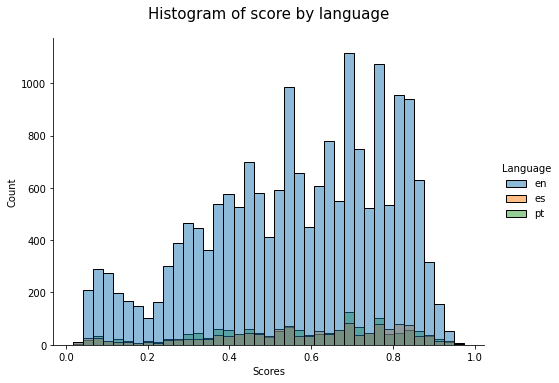

In [9]:
sns.displot(data=train, x= 'total_rel_score', aspect=1.4, hue='Language')
plt.title('Histogram of score by language', fontsize=15, pad=20)
plt.xlabel('Scores')

Plot above indicate us there is no outliers within data, another great new! However we can notice that papers at english language overcome to ones created in other languages.

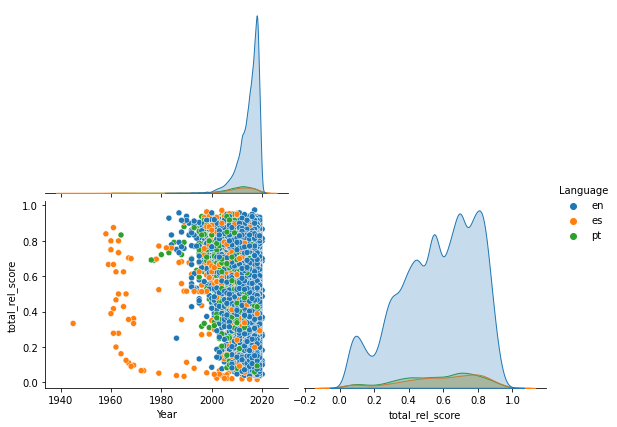

In [10]:
sns.pairplot(train.drop(columns=['id']), hue='Language', corner=True, aspect=1.3, height=3)

In another hand, there is a clear separation between papers at spanish language in early years and rest of papers.

## Preprocessing

### Creating dummy variables for Language

In [11]:
dummy_language = OneHotEncoder(dtype='int8')
df_dummy_language = dummy_language.fit_transform(train[['Language']]).toarray()

In [12]:
train = train.join(pd.DataFrame(df_dummy_language, columns=dummy_language.categories_[0]))

### MinMaxScaler to Year

In [13]:
minMaxScaler = MinMaxScaler()
year_minmax = minMaxScaler.fit_transform(train[['Year']])
train.Year = year_minmax

In [14]:
train.head()

,id,Language,Year,Abstract,Title,total_rel_score,en,es,pt
0,1,en,0.946667,The present study investigates an inventory mo...,Replenishment policy for non-instantaneous det...,0.630682,1,0,0
1,2,en,0.986667,AIM: To investigate the clinical characteristi...,Analysis of soldiers' orbital wall fracture su...,0.583333,1,0,0
2,3,en,0.986667,"Aflatoxin M1 (AFM1) and ochratoxin A (OTA), wh...","Modulation of Mucin (MUC2, MUC5AC and MUC5B) m...",0.372222,1,0,0
3,4,en,0.960000,Background/Aim: There are still unrevealed tre...,Traditional dentistry knowledge among Serbs in...,0.661765,1,0,0
4,5,en,0.933333,Impairment in empathy has been demonstrated in...,Dimensional schizotypy and social cognition: A...,0.373737,1,0,0


### Applying NLP

##### Tokenizing

In [15]:
# Loading spacy for every target language
nlp_en = spacy.load('en_core_web_sm')
nlp_es = spacy.load('es_core_news_sm')
nlp_pt = spacy.load('pt_core_news_sm')

# Stemmer from NLTK
stemmer_en = SnowballStemmer(language='english')
stemmer_es = SnowballStemmer(language='spanish')
stemmer_pt = SnowballStemmer(language='portuguese')

In [48]:
# Function for lemmatization, filtering stopword and length of words

def get_tokens(dataframe):
    '''
    dataframe: Pandas Dataframe with two columns 'Abstract' and 'Language'
    '''
    tokens_title = []
    for item in tqdm(dataframe.itertuples()):
        title = item.Abstract
        src_lang = item.Language
        # Create nlp object according to language
        if src_lang=='en':
            stemmer_lang = stemmer_en
            nlp_lang = nlp_en(title)
        elif src_lang=='es':
            stemmer_lang = stemmer_es
            nlp_lang = nlp_es(title)
        else:
            stemmer_lang = stemmer_pt
            nlp_lang = nlp_pt(title)

        # Filtering 
        tokens = [word.lemma_ for word in nlp_es(title) 
                  if word.pos_ not in ['PUNCT', 'SPACE', 'NUM']
                  and not word.is_stop                 
                  and len(word)>2
                ]
        tokens_title.append(' '.join(tokens))
    return tokens_title

In [49]:
%%time
train['Abstract_tokens'] = get_tokens(train[['Abstract', 'Language']])


CPU times: user 29min 25s, sys: 17.8 s, total: 29min 43s
Wall time: 29min 41s


In [50]:
train.head()

,id,Language,Year,Abstract,Title,total_rel_score,en,es,pt,Title_tokens,Abstract_tokens
0,1,en,0.946667,The present study investigates an inventory mo...,Replenishment policy for non-instantaneous det...,0.630682,1,0,0,replenishment policy for deteriorating items t...,The present study investigat inventory model f...
1,2,en,0.986667,AIM: To investigate the clinical characteristi...,Analysis of soldiers' orbital wall fracture su...,0.583333,1,0,0,Analysis soldiers orbital wall fracture surgic...,AIM investigate the clinical characteristics a...
2,3,en,0.986667,"Aflatoxin M1 (AFM1) and ochratoxin A (OTA), wh...","Modulation of Mucin (MUC2, MUC5AC and MUC5B) m...",0.372222,1,0,0,Modulation Mucin MUC2 MUC5AC and MUC5B mRNA Ex...,Aflatoxin AFM1 and ochratoxin OTA which widely...
3,4,en,0.960000,Background/Aim: There are still unrevealed tre...,Traditional dentistry knowledge among Serbs in...,0.661765,1,0,0,Traditional dentistry knowledge among Serbs se...,Background Aim There are still unrevealed trea...
4,5,en,0.933333,Impairment in empathy has been demonstrated in...,Dimensional schizotypy and social cognition: A...,0.373737,1,0,0,Dimensional schizotypy and social cognition fm...,Impairment empathy haber been demonstrated pat...


##### Vectorization

In [51]:
vectorizer_model = TfidfVectorizer(min_df=450, encoding='ascii')
vectorizer_values = vectorizer_model.fit_transform(train['Abstract_tokens'])

In [52]:
train_with_tfidf = train.join(pd.DataFrame(vectorizer_values.toarray(), 
                        columns=vectorizer_model.get_feature_names())
        )

### Dropping unnecessary columns:

In [60]:
COLS = ['id', 'Abstract', 'Title', 'Language', 'Abstract_tokens']
train_with_tfidf.drop(COLS, axis=1, inplace=True)

In [61]:
train_with_tfidf.head()

,Year,total_rel_score,en,es,pt,05,10,95,ability,able,about,abstract,according,account,accuracy,achieved,acid,across,action,activation,active,activities,activity,acute,addition,additional,address,affect,affected,after,against,age,aged,aim,aimed,aims,all,along,also,although,...,value,variable,various,very,via,view,vitro,was,water,way,weeks,weight,well,werar,were,werir,what,when,where,whereas,whether,which,while,who,whole,wide,widely,will,with,within,without,women,work,world,would,year,years,yet,yield,él
0,0.946667,0.630682,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.00000,0.0,0.000000,0.0,0.126307,0.0,...,0.099026,0.0,0.091565,0.000000,0.0,0.119483,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.107346,0.000000,0.086175,0.000000,0.0,0.000000,0.0,0.070889,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000
1,0.986667,0.583333,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.082649,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.125823,0.0,0.075183,0.0,0.071742,0.00000,0.0,0.119768,0.0,0.000000,0.0,...,0.000000,0.0,0.000000,0.083638,0.0,0.000000,0.0,0.036571,0.0,0.000000,0.0,0.0,0.000000,0.0,0.308143,0.0,0.0,0.000000,0.0,0.000000,0.0,0.045580,0.000000,0.073182,0.000000,0.0,0.000000,0.0,0.030100,0.0,0.0,0.0,0.072939,0.0,0.0,0.000000,0.067639,0.000000,0.0,0.044636
2,0.986667,0.372222,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.074529,0.0,0.000000,0.0,0.000000,0.10334,0.0,0.070942,0.0,0.000000,0.0,...,0.099624,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.073687,0.0,0.000000,0.0,0.0,0.082394,0.0,0.000000,0.0,0.107995,0.000000,0.000000,0.000000,0.0,0.122303,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.105758
3,0.960000,0.661765,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.097149,0.0,0.000000,0.0,0.000000,0.102172,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.071582,0.00000,0.0,0.000000,0.0,0.000000,0.0,...,0.000000,0.0,0.155172,0.083452,0.0,0.000000,0.0,0.109468,0.0,0.088931,0.0,0.0,0.062062,0.0,0.115297,0.0,0.0,0.000000,0.0,0.095985,0.0,0.000000,0.069034,0.000000,0.101787,0.0,0.000000,0.0,0.030033,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.101702,0.0,0.044537
4,0.933333,0.373737,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.228935,0.0,0.160011,0.000000,0.0,0.0,0.0,0.000000,0.0,0.075726,0.0,0.000000,0.00000,0.0,0.060316,0.0,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.062650,0.0,0.038796,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.151589,0.0,0.0,0.0,0.000000,0.0,0.0,0.090201,0.068128,0.000000,0.0,0.000000


## Training

In [62]:
X = train_with_tfidf.drop(['total_rel_score'], axis=1)
y = train_with_tfidf.total_rel_score

In [63]:
SEED = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED, shuffle=True)

In [64]:
%%time
model = RandomForestRegressor(max_depth=14, n_estimators=70, verbose=2,
                     n_jobs=mp.cpu_count(), random_state=SEED)
model.fit(X_train, y_train)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 70
building tree 2 of 70
building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70


[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:   43.9s


building tree 39 of 70
building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 45 of 70
building tree 46 of 70
building tree 47 of 70
building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70
CPU times: user 2min 38s, sys: 348 ms, total: 2min 38s
Wall time: 1min 21s


[Parallel(n_jobs=2)]: Done  70 out of  70 | elapsed:  1.4min finished


In [65]:
def results_metric(model):
    # Predict for train and test
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # RMSLE metric
    rmsle_train = np.sqrt(mean_squared_log_error(y_train, y_pred_train))
    rmsle_test = np.sqrt(mean_squared_log_error(y_test, y_pred_test))

    # Plotting results
    plt.figure(figsize=(12, 5))
    sns.set(color_codes=True)
    plt.subplot(1, 2, 1)    
    sns.histplot(y_train - y_pred_train, bins=20, kde=True, color='g')
    sns.histplot(y_test - y_pred_test, bins=20, kde=True, color='r')
    plt.legend(['Train','Test'])
    plt.subplot(1, 2, 2)
    sns.scatterplot(x=y_test, y=y_pred_test)
    sns.set(None)
    lims = [
        np.min([plt.xlim(), plt.ylim()]),  # min of both axes
        np.max([plt.xlim(), plt.ylim()]),  # max of both axes]
    ]

    plt.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    plt.xlabel('Y Test')
    plt.ylabel('Y Pred Test')
    print('RMSLE Train', rmsle_train)
    print('RMSLE Test', rmsle_test)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  70 out of  70 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  70 out of  70 | elapsed:    0.1s finished


RMSLE Train 0.11609903389857143
RMSLE Test 0.13800389359768597


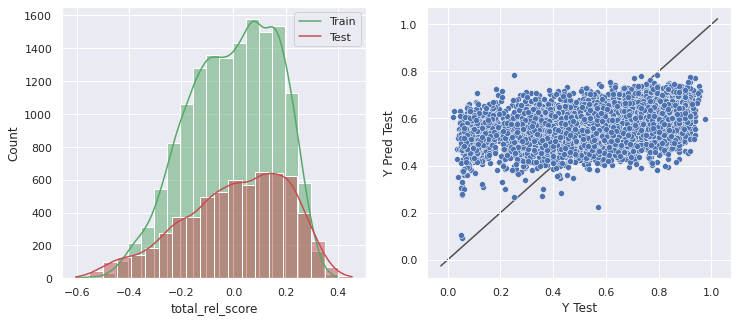

In [66]:
results_metric(model)

## Predictions

Preprocessing Test dataset

In [67]:
# Creating dummy variables from OneHotEncoder created previosly...
dummy_test = dummy_language.transform(test[['Language']]).toarray()

# Converting to Dataframe with named columns for dummy
dummy_test = pd.DataFrame(dummy_test, columns=dummy_language.categories_[0])

# Scaling Year
test.Year = minMaxScaler.transform(test[['Year']])

# Joining dummy columns to full test dataset
test = test.join(dummy_test)

Saving Id column for submission csv file:

In [68]:
id = test.id

Applying NLP

In [69]:
%%time
test['Abstract_tokens'] = get_tokens(test[['Abstract','Language']])


CPU times: user 14min 47s, sys: 9.64 s, total: 14min 57s
Wall time: 14min 55s


In [75]:
vectorizer_values_test = vectorizer_model.transform(test['Abstract_tokens'])
test_with_tfidf = test.join(pd.DataFrame(vectorizer_values_test.toarray(), 
                        columns=vectorizer_model.get_feature_names())
        )

Removing same columns as train dataset:

In [76]:
test_with_tfidf.drop(COLS, axis=1, inplace=True)

In [77]:
test_with_tfidf.head()

,Year,en,es,pt,05,10,95,ability,able,about,abstract,according,account,accuracy,achieved,acid,across,action,activation,active,activities,activity,acute,addition,additional,address,affect,affected,after,against,age,aged,aim,aimed,aims,all,along,also,although,among,...,value,variable,various,very,via,view,vitro,was,water,way,weeks,weight,well,werar,were,werir,what,when,where,whereas,whether,which,while,who,whole,wide,widely,will,with,within,without,women,work,world,would,year,years,yet,yield,él
0,0.933333,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.091691,0.0,0.0,0.102606,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.053898,0.0,0.000000,...,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.045807,0.0,0.0,0.0,0.0,0.0,0.0,0.060500,0.0,0.0,0.000000,0.073301,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.906667,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.081200,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.09769,0.000000,0.0,0.0,0.0,0.0,0.206961,0.0,0.10088,0.0,0.000000,0.0,0.0,0.087192,0.0,0.0,0.000000,0.0,0.0,0.0,0.051590,0.0,0.0,0.0,0.0,0.0,0.0,0.034069,0.0,0.0,0.413298,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.866667,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.079467,0.0,0.0,0.0,0.095507,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.068209,...,0.084132,0.00000,0.000000,0.0,0.0,0.0,0.0,0.109761,0.0,0.00000,0.0,0.000000,0.0,0.0,0.038535,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.089216,0.0,0.0,0.0,0.0,0.0,0.0
3,0.813333,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.219373,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.973333,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.046605,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.042093,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.00000,0.091248,0.0,0.0,0.0,0.0,0.128744,0.0,0.00000,0.0,0.322105,0.0,0.0,0.090399,0.0,0.0,0.040808,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.158948,0.0,0.0,0.000000,0.042795,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [82]:
y_pred = model.predict(test_with_tfidf)
predictions = pd.DataFrame({'id':id, 'total_rel_score':y_pred})
predictions.head()

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  70 out of  70 | elapsed:    0.1s finished


,id,total_rel_score
0,1,0.634846
1,2,0.616163
2,3,0.637646
3,4,0.674859
4,5,0.543298


In [83]:
predictions.to_csv(PREFIX+'/SampleSubmission.csv', index=False)